# Create dataset

In [110]:
from PIL import Image
import glob
import os.path

base_dir = 'd:/clustering/' # images are expected to be in subfolders of this folder (no nested subfolders)
resized_suffix = '_resized'

size = (240, 240)
images = []
for filename in glob.glob(base_dir + '*/*.jpg'):
    if resized_suffix in filename: continue # make sure we don't process the files we already resized
    resized_filename = os.path.splitext(filename)[0] + resized_suffix + '.jpg'
    if not os.path.isfile(resized_filename):
        image = Image.open(filename)
        image.thumbnail(size, Image.ANTIALIAS)
        image.save(resized_filename, "JPEG")
    images.append(Image.open(resized_filename))

print("prepared " + str(len(images)) + " images")

prepared 243 images


# Extract Features

In [121]:
X = np.ones(shape=(len(images), 0)) # initialize feature matrix X
X.shape

(243, 0)

## HSV histogram

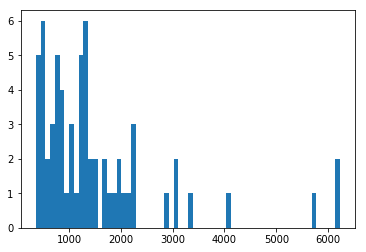

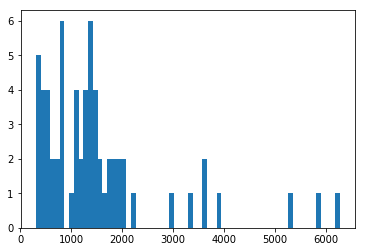

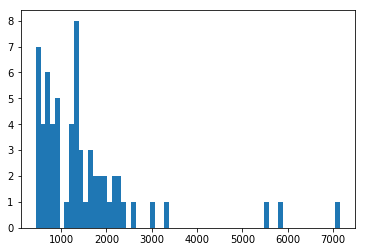

In [136]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

n_features = 64
features = np.zeros(shape=(len(images), n_features)) # initialize feature matrix

for i, image in enumerate(images):
    features[i] = np.histogram(image.convert('HSV'), bins=n_features)[0]
    if i < 3: 
        plt.hist(features[i], bins=n_features)
        plt.show()

X = np.column_stack((X, features)) # add new features to feature matrix X

## Edge histogram

In [134]:
from skimage.filters import sobel

n_features = 5
features = np.zeros(shape=(len(images), n_features)) # initialize feature matrix

for i, image in enumerate(images):
    edges = sobel(image.convert('HSV').getchannel('V'))
    features[i] = np.histogram(edges, bins=n_features)[0]
    if i < 3: 
        plt.hist(featrues[i], bins=n_features) # TODO how am i supposed to do that edge histogram thing?
        plt.show()

X = np.column_stack((X, features)) # add new features to feature matrix X

ValueError: could not broadcast input array from shape (10) into shape (5)

# K-means clustering

In [129]:
from sklearn.cluster import KMeans
import re, shutil

kmeans = KMeans(n_clusters=30, random_state=0).fit(X)

images_by_cluster = sorted(zip(images, kmeans.labels_), key=lambda x: x[1]) # create sorted list of (<image>, <cluster>) pairs

base_dir = 'd:/clusters/'
shutil.rmtree(base_dir)
for image, cluster in images_by_cluster: # save images in a directory per cluster
    cluster_dir = base_dir + str(cluster)
    if not os.path.exists(cluster_dir):
        os.makedirs(cluster_dir)
    image_name = cluster_dir + '/' + re.split("[/\\\]", image.filename)[-1]
    image.save(image_name, 'JPEG')


#kmeans.labels_
#kmeans.cluster_centers_


